---
title: "How to build your own vector search engine"
description: "Leverage open-source AI to create a powerful vector search engine with ease."
date: 2023-04-20
categories: [tutorial]
draft: true
reference-location: margin
toc-depth: 5
---

In [ ]:
#|echo: false
%load_ext autoreload
%autoreload 2

![](images/vector-search.png){.preview-image}

I built a vector search engine named [Meepo](https://meepo.shop) for a local (South African 🇿🇦) eCommerce store. Thanks to the power and availability of foundational neural networks, open-source software, and cloud infrastructure -- along with a touch of good planning -- the entire process took me just one week, and it costs me a mere $30 per month to host.

Honestly, it blows my mind that this is possible. Decades of hard work by some of the brightest minds have enabled us to create and distribute incredible AI-powered products from almost anywhere in the world.

**In this post, I show you how to build your own vector search engine.**

By the end of the post you'll be able to search through a dataset of pet images for queries as obscure as "a fluffy pink cat on a tv" -- and it'll work! You'll also have a concrete idea of how to structure and deploy your own search engine.

We'll get there in three parts:

- **[Part 1: Background](#part-1-background).** We discuss why you might need vector search over regular search, how the underlying technology works, and its little-known roots in the medical domain.
- **[Part 2: Let's build a search engine for the Oxford Pets dataset](#part-2-lets-build-a-clip-search-engine-for-the-oxford-pets-dataset).** We build the core of our own vector search engine from scratch. We use a dataset with a good size and complexity to demonstrate the power of the technique without slowing down iteration. However, I urge you to try it out on your own dataset too!
- **[Part 3: Tips for deploying your search engine](#part-3-tips-for-deploying-your-search-engine).** I share how Meepo is architected and deployed, as well as a few tips that you might find helpful to ship your search engine quickly and cheaply.

## Part 1: Background

### Why do we need vector search?

I built Meepo out of frustration with existing search engines. I needed a fork, so naturally I tried to search for "fork" on my favourite online store, but the result contained only 4 items -- none of which resemble a fork at all!

![](images/normal-fork.png)

It turns out, I had to search "cutlery" instead, because that's how the items happen to be tagged in the store's catalogue.

On the other hand, here are the first few results with Meepo. So many forks!

![](images/vector-fork.png)

**Why the difference?**

Whereas conventional search engines work by matching the text in your query with labels attached to each image, modern semantic search engines leverage neural networks for a deeper understanding of what's represented by the pixels in the image and the text in their labels.

This means that queries like "fork" work, regardless of how each item is labelled. It also means that you can get far more creative with your queries, including colors, textures, patterns, and more!

For example, here is the top search result for "fluffy striped salmon pillow":

![](images/fluffy-striped-salmon-pillow.png){fig-align=center width=200px}

Incredible! And even more incredible is how easy it is to build your own such vector search engine thanks to a powerful and open-source technology: Contrastive Language-Image Pretraining (CLIP).

### What's CLIP?

Contrastive Language-Image Pretraining (CLIP) is a technique for training neural networks with state-of-the-art zero-shot performance on a variety of tasks using mixed image and text data.[^sota] By "zero-shot" we mean that the model was not trained on any examples from a given dataset.

[^sota]: While CLIP has been dethroned several times in the last two years (most recently by [BLIP-2](http://arxiv.org/abs/2301.12597)), it is still notable for introducing a step change improvement in the power of zero-shot multimodal techniques.

![A visualization of the contrastive language-image pretraining approach. Source: [CLIP: Connecting Text and Images](https://openai.com/blog/clip/) by OpenAI.](images/clip-training.png){width=600 fig-align=center}

The idea is to pretrain a neural network to predict the most relevant text snippet given an image and vice versa.

**But the trick is to use a *contrastive* rather than a predictive objective.**

What does that mean?

A predictive objective takes an input image and tries to predict its corresponding text snippet.

On the other hand, a contrastive objective predicts a vector for each image and another vector for each text snippet; these vectors are called _embeddings_. It does so in such a way that corresponding image and text vectors are more _similar_ (according to some chosen similarity function) and non-corresponding image and text vectors are less similar.

OpenAI found that a contrastive objective reached the same zero-shot ImageNet accuracy as the predictive objective while using 4x fewer training examples!

### ConVIRT: The little-known medical roots of CLIP

Interestingly, the technique described above was originally introduced as ConVIRT [(Zhang et al. 2020)](https://arxiv.org/abs/2010.00747), which demonstrated the approach on 217k medical image-text pairs (~2000x fewer than CLIP).

![X-ray images with naturally occurring paired descriptions from doctor's reports. Source: Figure 1 of Zhang et al., 2020](images/meepo-convirt-examples.png){width=400 fig-align=center}


Despite being acknowledged in the [CLIP paper](https://arxiv.org/abs/2103.00020), I hadn't heard of ConVIRT until I read the CLIP paper myself:

> **[...] we create a new dataset of 400 million (image, text) pairs and demonstrate that [a simplified version of ConVIRT trained from scratch, which we call CLIP]{.hl-yellow}, for Contrastive Language-image Pre-training, is an efficient method of learning from natural language supervision.**

As with most machine learning innovations, [it all starts with data](https://vicki.substack.com/p/neural-nets-are-just-people-all-the). High-quality annotations of medical images are expensive to make.

**ConVIRT's key insight was to mine doctor's reports _in their natural language format_ for image-text pairs.**

OpenAI's later contribution was largely an engineering effort. They scaled ConVIRT up to a 2000x larger dataset---400 million examples in total! Of course, that itself is a mighty task.

Now that we have some background on CLIP and its impressive zero-shot capabilities, how do we actually use it to create a semantic search engine like Meepo?

## Part 2: Let's build a CLIP search engine for the Oxford Pets dataset

In this section, we'll build our own CLIP-based semantic search engine on the Oxford Pets dataset.

I chose the Oxford Pets dataset since it's a good size and complexity to demonstrate the power of CLIP, but I urge you to try this out on your own dataset too.

We'll do this in two steps:

- First, we'll use CLIP as a convenient zero-shot classifier.
- Then we'll show how to use the same underlying functions for text-to-image search.

By the end of the section you will be able to search for queries as obscure as "a fluffy pink cat on a tv" -- and it'll work!

### The Oxford Pets dataset

First install these required libraries:

- [HuggingFace Datasets](https://huggingface.co/docs/datasets/index): easily access and share datasets for a variety of machine learning tasks.
- [HuggingFace Transformers](https://huggingface.co/docs/transformers/index): easily download, train, and use state-of-the-art pretrained neural networks.

In [ ]:
#| output: false
!pip install datasets transformers

Then load the [Oxford Pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset -- thanks to [Pedro Cuenqa](https://twitter.com/pcuenq) for uploading it:

In [ ]:
#| output: false
from datasets import load_dataset

dataset = load_dataset("pcuenq/oxford-pets")

Using custom data configuration pcuenq--oxford-pets-43375e644eed3d52


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/seem/.cache/huggingface/datasets/pcuenq___parquet/pcuenq--oxford-pets-43375e644eed3d52/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

One of the most important rules of machine learning is to always look at the data. This is quite easy with images, since we can just show the image.

Let's define a helper function to show thumbnails of an image:

In [ ]:
import numpy as np

def thumbnail(image, scale=3):
    return image.resize(np.array(image.size)//scale)

Here's an example of a cat:

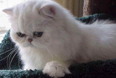

In [ ]:
cat_row = dataset['train'][15]
cat_image = cat_row['image']
thumbnail(cat_image)

... and here's an example of a dog:

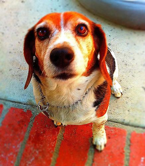

In [ ]:
dog_row = dataset['train'][10]
dog_image = dog_row['image']
thumbnail(dog_image)

### Using CLIP for zero-shot classification

Now that we have a dataset, we can load the CLIP processor and model. The concept of having a separate _processor_ and _model_ is central to the HuggingFace Transformers library, since it allows us to use 174 state-of-the-art models (as of writing this article) with a very similar API.

Note that it might take a minute to download the pretrained weights:

In [ ]:
from transformers import CLIPProcessor, CLIPModel

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

The `CLIPProcessor` prepares the inputs for the `CLIPModel` which can then be used to obtain embedding vectors. Let's create a function to embed an image by first passing it through the processor and then into the model:

In [ ]:
import torch

def embed_image(images):
    if not isinstance(images, list): images = [images]
    inputs = processor(images=images, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_image_features(**inputs)

Test that it works:

In [ ]:
images = [cat_image, dog_image]
image_embs = embed_image(images)
image_embs.shape

torch.Size([2, 512])

You can also pass text to the `CLIPProcessor`. Let's create a similar function to embed text inputs:

In [ ]:
def embed_text(text):
    inputs = processor(text=text, return_tensors="pt", padding=True)
    with torch.no_grad(): return model.get_text_features(**inputs)

In [ ]:
text_embs = embed_text([f"a photo of a {cls}" for cls in ["cat", "dog"]])
text_embs.shape

torch.Size([2, 512])

We can now use embeddings for zero-shot classification by using text inputs that represent the different classes, and then calculating the _cosine similarity_ between image embeddings and text embeddings.

Cosine similarity is calculated by taking the dot product of normalized vectors:

In [ ]:
def normalize(a): return a / a.norm(dim=-1, keepdim=True)
def cosine_sim(a, b): return normalize(a) @ normalize(b).T

In [ ]:
cosine_sim(image_embs, text_embs)

tensor([[0.2639, 0.2127],
        [0.1962, 0.2553]])

Note how the similarity between the cat image and the text "a photo of a cat" (0.2639) is higher than the similarity between the cat image and the text "a photo of a dog" (0.2127), and similarly for the dog image in the next row of the tensor.

We can convert these similarities to probabilities by using the model's `logit_scale` parameter followed by the `softmax` method:

In [ ]:
def logits(a, b): return model.logit_scale.exp() * cosine_sim(a, b)
def probs(a, b): return logits(a, b).softmax(dim=0)

In [ ]:
probs(text_embs, image_embs)

tensor([[0.9940, 0.0027],
        [0.0060, 0.9973]], grad_fn=<SoftmaxBackward0>)

We see a probability of 0.994 that the image of a cat is in fact a cat, and a probability of 0.997 that the image of a dog is in fact a dog. Pretty good!

Since this is a zero-shot classifier, we can very easily generalize it to arbitrary classes! Let's make a convenient wrapper to do exactly that:

In [ ]:
def classify(image, classes, template="a photo of a {}"):
    image_embs = embed_image(image)
    text_embs = embed_text([template.format(o) for o in classes])
    return probs(text_embs, image_embs)

To use this, simply pass in a list of classes. You can also customize the `template`, which can improve the classification accuracy.

Here's how we can classify the breed of a cat:

In [ ]:
cat_breeds = sorted({row["label"] for row in dataset["train"] if not row["dog"]})
scores = classify(cat_image, cat_breeds, "a photo of a {} cat")
scores

tensor([[1.2116e-05],
        [5.4131e-06],
        [4.6950e-02],
        [1.9504e-06],
        [2.1754e-02],
        [1.7998e-04],
        [9.0918e-04],
        [9.1228e-01],
        [1.7194e-02],
        [4.6431e-05],
        [5.8636e-04],
        [7.8781e-05]], grad_fn=<SoftmaxBackward0>)

In [ ]:
idx = torch.argmax(scores)
cat_breeds[idx], scores[idx].item()

('Persian', 0.9122824668884277)

... and here's how we can classify the color of any animal:

In [ ]:
classes = ["black", "white", "red", "green", "yellow", "blue", "brown", "orange", "pink", "purple", "grey"]
scores = classify(cat_image, classes, "a photo of a {} animal")
idx = torch.argmax(scores)
classes[idx], scores[idx].item()

('white', 0.8672362565994263)

It works -- and it's super convenient too!

### Using CLIP for text-to-image search

Using CLIP for search is not too different from using it for zero-shot classification. In fact, search is even simpler! We don't need to calculate probabilities since we ultimately only care about the order of items:

In [ ]:
def search(image_embs, query_embs):
    sims = cosine_sim(image_embs, query_embs).flatten()
    indices = sims.argsort(descending=True)
    return indices, sims[indices]

In [ ]:
indices, sims = search(image_embs, embed_text("a photo of a cat"))
indices, sims

(tensor([0, 1]), tensor([0.2639, 0.1962]))

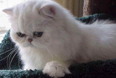

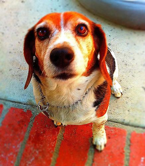

In [ ]:
for i in indices: display(thumbnail(images[i]))

Let's try that with a bigger dataset and some more interesting queries:

Let's embed all of the images. Since this took quite a while on my laptop (19 minutes), it's convenient to cache the result to disk so that we don't slow down iteration in our notebook:

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

In [ ]:
all_image_embs_path = Path("oxford_pets_embeddings.npy")
if all_image_embs_path.exists():
    all_image_embs = torch.tensor(np.load(all_image_embs_path))
else:
    all_image_embs = [embed_image(row['image']) for row in tqdm(dataset['train'])]
    np.save(all_image_embs_path, embs)

In [ ]:
all_image_embs.shape

torch.Size([7390, 512])

In [ ]:
def search_and_display(image_embs, query_embs, k=3):
    indices, _ = search(image_embs, query_embs)
    for i in indices[:k]:
        image = dataset["train"][i.item()]["image"]
        display(thumbnail(image))

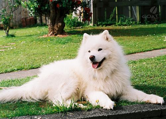

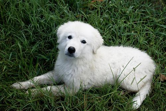

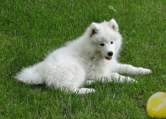

In [ ]:
search_and_display(all_image_embs, embed_text("a photo of a white puppey on the grass"))

Amazing! I wonder how obscure we can get?

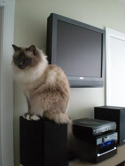

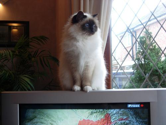

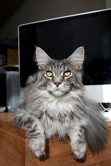

In [ ]:
search_and_display(all_image_embs, embed_text("a photo of a fluffy pink cat on a tv"))

It always surprises me how well this works! 🤯

And once again, it's super flexible. For example, all we need to change in order to use an image query is to pass the image's embeddings instead of text embeddings!

Let's find the most similar images to our fluffy white persian cat from earlier:

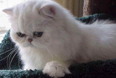

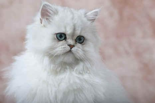

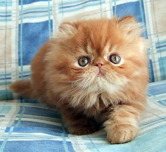

In [ ]:
search_and_display(all_image_embs, embed_image(cat_image))

Now that we have a working CLIP-based vector search engine, how do we share it with the world?

## Part 3: Tips for deploying your search engine

In this section, I'll share a few tips that you might find helpful in deploying your own search engine based on my experience with Meepo.

### How Meepo works

Meepo (as with most machine learning applications) consists of the following two sub-systems:

1. **Data pipeline:** A set of scripts responsible for maintaining the data that powers the search engine. This includes scraping, running images through CLIP, and maintaining the data storage components (detailed further below).
2. **Web app:** A simple search form in front of a CLIP-based search engine (as described in [part 2](#part-2-lets-build-a-clip-search-engine-for-the-oxford-pets-dataset)). The app reads from the application database and vector search index (written to by the data pipeline), and renders HTML/CSS to the user.

![](images/vector-search-engine.png)

Data storage consists of two components that are updated by the data pipeline and then read from by the web app:

1. **Application database:** A typical relational database that contains all of the products in the search catalogue, along with associated metadata.
2. **Vector search index:** An index for fast approximate nearest neighbour vector search. I used [faiss](https://github.com/facebookresearch/faiss), although there are other options like [hnswlib](https://github.com/nmslib/hnswlib), as well as more full-featured vector search databases like [Milvus](https://milvus.io/), [Pinecone](https://www.pinecone.io/), [Qdrant](https://qdrant.tech/), and [Weaviate](https://weaviate.io/).

#### Tech stack

As for the specific tech choices, here's the full stack powering Meepo:

- [Contrastive language-image pretraining](#whats-clip): the deep learning method powering Meepo's search.
- [Faiss](https://github.com/facebookresearch/faiss): a fast approximate nearest neighbour vector search index.
- [Conda](https://docs.conda.io/en/latest/): a Python package management system.
- [nbdev](http://nbdev.fast.ai/): a platform for developing software using [Jupyter](https://jupyter.org/) notebooks.
- [Tailwind CSS](https://tailwindcss.com/): a simpler CSS framework.
- [DaisyUI](https://daisyui.com/): a component library built on Tailwind CSS.
- [SQLite](https://www.sqlite.org/): a light but powerful database engine.
- [Django](https://www.djangoproject.com/): a battle-tested Python web framework.
- [Gunicorn](): a Python HTTP server that lets us serve our Django application.
- [Nginx](https://www.nginx.com/): a powerful and customizeable web server.
- [Cron](https://cron.com/): a job scheduler built into Unix operating systems.
- [Linode](https://www.linode.com/): a cloud hosting provider.

#### Infrastructure

I developed and tested an MVP locally on a small subset of data. Once I was happy with that, I deployed it to a Linode 4 GB Shared CPU VPS (2 CPUs, 4GB RAM, 80GB storage) costing \$24 per month, and subscribed to Linode's backup service for an additional \$5 per month.

::: callout-note

##### Why use a VPS instead of a modern platform as a service option?

Most people underestimate how much traffic you can serve from a single low cost VPS!

[Pieter Levels](https://twitter.com/levelsio), a well-known solopreneur, ran more than 40 of his websites serving over 250 million requests per month [from a single VPS](https://twitter.com/levelsio/status/1641728236617887744).

[Marginalia](https://memex.marginalia.nu/), an indie search engine that focuses on non-commercial content, casually handled the front page of Hackernews [with a single server worth ~\$5k of commercial hardware](https://news.ycombinator.com/item?id=35614187) in their living room.

My good friend [Ashton Hudson](https://twitter.com/ashtonshudson) took the same approach with [Serval](https://www.servaltracker.com/), a price tracker for South Africa's largest online store, which serves X requests per month and stores Y time series data points on [low cost servers costing ~\$45 per month](https://twitter.com/ashtonshudson/status/1609621491481460737).

:::

I totally overestimated how much effort it would take to setup a VPS. It wasn't that bad and took a few hours in the end. Here's how I went about it. Note that these steps only need to be carried out once per server:

1. **Rent a VPS:** There are plenty of options available. I chose Linode for no particular reason.
2. **Setup your VPS:** This includes updating packages, setting the timezone and hostname, creating a limited user, and tightening SSH settings. I followed [this Linode guide](https://www.linode.com/docs/products/compute/compute-instances/guides/set-up-and-secure/).
3. **Setup nginx:** I followed [this Real Python guide](https://realpython.com/django-nginx-gunicorn).

Once your server is setup, you'll need to follow a few more setups for your app (and each future app you create):

1. **Setup Gunicorn:** I followed [the same Real Python guide](https://realpython.com/django-nginx-gunicorn) from above.
2. **Setup your domain name:** Buy a domain name and configure your VPS to use it. I searched for the cheapest name containing "meepo" and was lucky to score [meepo.shop](https://meepo.shop) at $2!
3. **Deploy your web app:** I followed [Django's official deployment guide](https://docs.djangoproject.com/en/4.2/howto/deployment/).
4. **Deploy your pipeline:** I kept it simple and added a [crontab](https://man7.org/linux/man-pages/man5/crontab.5.html) entry to a single shell script.

### Choosing boring tech

You might have noticed that I chose a "boring" tech stack. I believe that [boring tech](https://boringtechnology.club/) is a key part of what allowed me to ship Meepo so quickly. Let me explain.

#### Boring tech is old, because it works

It's been around for decades. If that's the case, and it's still widely used, then _it probably works_! It might not be the most elegant solution, but it gets the job done. Software that's been maintained for a long time is software that's been hardened against many thousands of obscure edge-cases that users like you and I no longer have to worry about.

For example, Meepo is a Django application, and Django is 20 years old. That's 20 years of incremental improvements and bug fixes resulting in a truly robust piece of software.

#### Try learning new process instead of new tech

Developers typically enjoy learning new tools. That's a good thing, but it also means that we're biased to choosing new tools even when they aren't necessarily improvements over the status quo.

Instead of focusing on learning a new tool, try to focus on mastering tools you already know, and developing excellent decision-making skills on top of those tools with a ruthless focus on shipping quickly.

For me, this meant using Django instead of something like FastAPI, and using a simple Linux VPS instead of a more modern platform as a service option. But this is different for everyone and depends on each person's individual experience.

#### Deviating from what works

Of course, absolute rules are rarely a good idea in any domain as complex as software. There are definitely cases where less boring tech can be a good idea -- I try to have a very specific reason before deviating from my favorite boring tools.

For example, I developed Meepo entirely in Jupyter notebooks. It sounds crazy, I know! But there's something about [notebook-driven development](https://nbdev.fast.ai/) that I can't quite shake. It makes programming feel like a game. There's constant feedback, very quick iteration cycles, and everything is within reach: code, rich docs, and tests all in one place. In fact, the second part of this post was based on the same notebooks that run Meepo.

### Being a responsible digital citizen

If I'm scraping a website, I'm most likely not the website's intended audience, so I try very hard not to negatively impact the user experience of their intended audience.

Legal concerns around web scraping are pretty vague. However, as long as you provide value to the underlying service, they probably won't mind you scraping them. For example, nobody cares that Google scrapes their sites because they provide traffic via search. Similarly, fashion stores that Meepo scrapes probably won't mind the extra traffic it brings them.

Here are some more detailed tips for scraping responsibly:

- Check how big the viewership of the website is. I would personally be hesitant to scrape a small website and would probably prefer to email the owner directly.
- Identify yourself with contact information via the user agent header – don't try to fake being a human! A simple pattern you can use is `your.website.com/x.y (your@email.com)` where `x.y` is your scraper's version number.
- Be considerate about their resource usage, especially since you aren't their intended audience.
- Do the bulk of your requests during off-peak times depending on the local timezone of their audience.
- Sleep between requests as much as you possibly can. Add small random amounts as well to reduce the likelihood of overlapping with other scheduled scrapers and bots, thus reducing peak load.
- Use compression when scraping plain text or JSON to minimise their outgoing traffic. It doesn't work nearly as well for images so it's probably best to not compress them to avoid extra CPU usage on their servers.

## Your turn

Now it's your turn. Dive into [the accompanying notebook](https://github.com/seeM/blog/blob/main/posts/how-to-build-your-own-semantic-search-engine.ipynb) for this post, give it a try with your own dataset, deploy the result, and share what you create!

**If you found this enjoyable, consider giving it a thumbs up below, commenting, and following me at [@wasimlorgat on Twitter](https://twitter.com/wasimlorgat). The positive feedback really helps me get a sense of what readers find valuable!**

---

_Many thanks to [Kurian Benoy](https://kurianbenoy.com/), [Jeremy Howard](https://www.fast.ai/), [Pedro Cuenca](https://twitter.com/pcuenq), and [Salman Naqvi](https://forbo7.github.io/), for their kind and thoughtful comments on various versions of this post._